### Autors
- Eric Chaves Sánchez - 1633944  
- Enric Rodríguez Bafalluy - 1632398


# League Of Legends Dataset

Utilitzem el dataset de kaggle que trobem a <a href="https://www.kaggle.com/datasets/datasnaek/league-of-legends">https://www.kaggle.com/datasets/datasnaek/league-of-legends</a> que és un dataset amb dades sobre el videojoc 
League Of Legends, el nostre objectiu és crear un model el qual sigui capaç de predir si una partida s'ha guanyat o no.



In [267]:
from zipfile import ZipFile
from copy import deepcopy
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
import seaborn as sns
from sklearn.metrics import  precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
from sklearn.linear_model import LogisticRegression
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

api = KaggleApi()
#api.config  = os.path.join(os.getcwd(),'kaggle.json')
api.authenticate()

dataser_owner = 'datasnaek'
dataset_name= 'league-of-legends'
dataset = f'{dataser_owner}/{dataset_name}'

if not os.path.isdir('data_kaggle'):
  os.mkdir('data_kaggle')
  api.dataset_download_files(dataset = dataset,path = 'data_kaggle')
  zf = ZipFile(f'data_kaggle/{dataset_name}.zip')
  zf.extractall(f'data_kaggle/{dataset_name}') #save files in selected folder
  zf.close()
df = pd.read_csv(f'data_kaggle/{dataset_name}/games.csv')
print(df.head(10))

       gameId   creationTime  gameDuration  seasonId  winner  firstBlood  \
0  3326086514  1504279457970          1949         9       1           2   
1  3229566029  1497848803862          1851         9       1           1   
2  3327363504  1504360103310          1493         9       1           2   
3  3326856598  1504348503996          1758         9       1           1   
4  3330080762  1504554410899          2094         9       1           2   
5  3287435705  1501667992132          2059         9       1           2   
6  3314215542  1503430065724          1993         9       1           1   
7  3329224025  1504472363684          1334         9       1           1   
8  3318040883  1503686577549          1387         9       2           2   
9  3327786881  1504385918871          2681         9       2           2   

   firstTower  firstInhibitor  firstBaron  firstDragon  ...  t2_towerKills  \
0           1               1           1            1  ...              5   
1      

Ara carreguem un arxiu anomenat champion_info.json que ens proporciona el mateix dataset de kaggle, l'utilitzarem més endavant. 

In [268]:
file_path=f"data_kaggle/{dataset_name}/champion_info.json"

with open(file_path, 'r', encoding='utf-8') as file:
    data_json = json.load(file)
    file.close()
#print(data)

### 1. EDA (exploratory data analysis)
Veiem que la nostra base de dades té 61 atributs. On tenim tant atributs numèrics continus com són: creationTime, gameDuration. Tots els altres valors són valors discrets, perquè només poden prendre un cert conjunt de valors per exemple GameId només pren uns valors que es troben en un rang acotat. Les columnes que són "bans" o "champ" també prenen uns valors concrets que són els números identificadors de personatges que hi ha al joc. No trobem Nans en les dades. 
A simple vista no trobem cap relació entre Y(winner) i les altres dades. 
Les dades no es troben massa balancejades als diferents atributs, el que ens podria arribar a afectar a la classificació.



In [269]:
print(df.shape)

missing_values = df.isna().sum()

print("\nValors faltants en cada atribut:")
print(missing_values)


(51490, 61)

Valors faltants en cada atribut:
gameId          0
creationTime    0
gameDuration    0
seasonId        0
winner          0
               ..
t2_ban1         0
t2_ban2         0
t2_ban3         0
t2_ban4         0
t2_ban5         0
Length: 61, dtype: int64


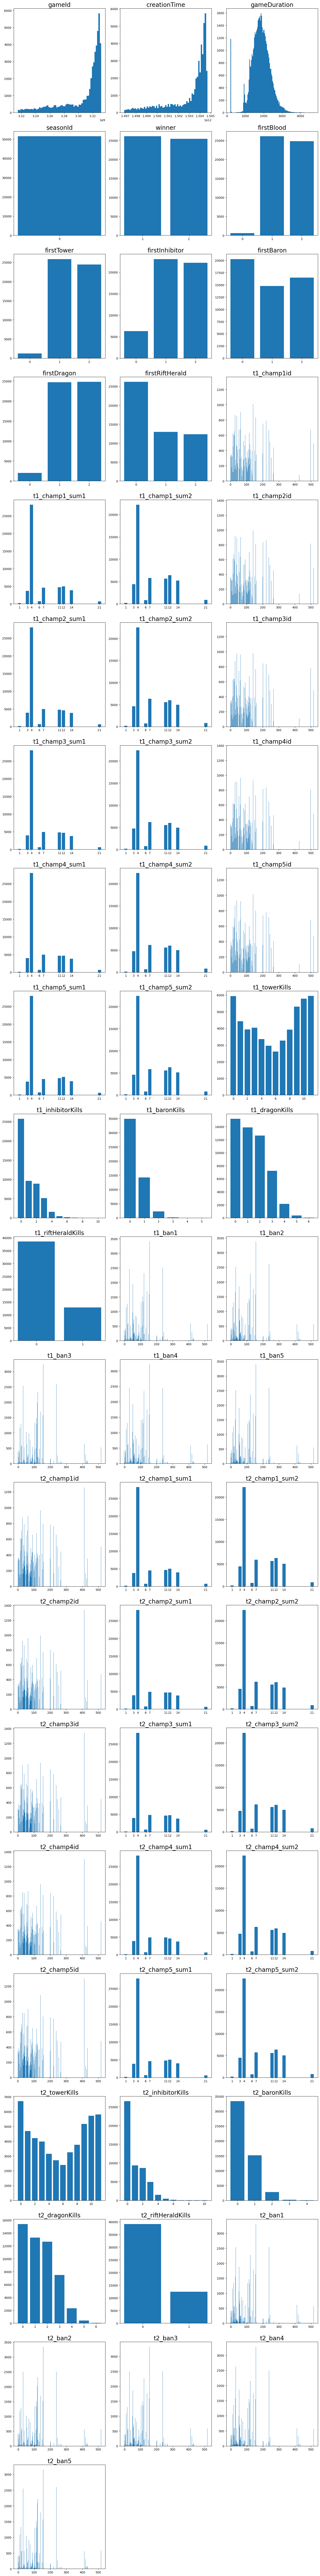

In [270]:
#tarda una bona estona ~2min
plt.figure(figsize=(15, 120))

m=1


for i in df: 
    plt.subplot(21,3, m)
    m+=1
    if i in ['gameId', 'creationTime', "gameDuration"]:  # Puedes añadir otros tipos numéricos si es necesario
        plt.hist(df[i], bins="auto")
        plt.title(i, fontsize=20)
    else:
        x=df[i].value_counts()
        
        plt.title(i, fontsize=20)

        plt.bar(x.keys(),x)
        if len(x.keys())<=10: 
            plt.xticks(x.keys(),  fontsize=10)

plt.tight_layout()
plt.show()

Finalment veiem que el dataset es troba balancejat sobre la classe que volem predir. 

In [271]:
df["winner"].value_counts(normalize=True)

winner
1    0.506448
2    0.493552
Name: proportion, dtype: float64

Mirem si gameId te valors repetits: 

In [272]:
if(df.shape[0]!=len(df["gameId"].unique())):
    print("Valors repetits en l'atribut gameId")

if(df.shape[0]!=len(df["creationTime"].unique())):
    print("Valors repetits en l'atribut creationTime")


Valors repetits en l'atribut gameId
Valors repetits en l'atribut creationTime


### 2. Preprocessing

GameId és l'identificador de la partida que es repeteix. No ens interessa perquè un mateix gameID tindrà sempre la mateixa predicció de si guanya o perd. 
Per tant, si dades amb el mateix GameID acaben en la partició de train i altres en la partició de test hi hauria una espècie de data leaking perjudicant el patró que reconeixeria el model.
I l'identificador de la sessió ("seasonId") té sempre el mateix valor, és a dir totes les partides són del mateix any/temporada, per tant no aporta cap informació. També hem optat per eliminar creationTime, ja que no ens dona cap informació extra, i com indica just el temps quan s'ha creat la partida, al igual que GameId dues partides que es creen al mateix instant de temps segurament són la mateixa, i podria passar que una acabes a la partició de train i una altre a la partició de test, fent data leaking.

In [273]:

df=df.drop(["gameId", "seasonId", "creationTime"], axis=1)
print(df.shape)

(51490, 58)


Al League of Legends que hi hagui en la variable gameDuration valors propers a zero vol dir que els jugadors de l'equip s'han rendit ràpidament(possiblement perquè un jugador s'ha desconnectat), això passa perquè el joc ens dona l'opció a abandonar quan passa això. Quan en aquest tipus de partida et rendeixes en un temps inferior al minut 5 no compta ni com a victòria ni derrota, aquestes partides no les tindrem en compte. Per tant, els valors anòmals que són inferiors 500 segons, que és un temps de partida molt petit els traiem perquè són rendicions o valors que no poden ocórrer.

In [274]:
df=filtrado = df[df['gameDuration'] > 500] 

Ara tornem a mirar els valors, ja que hi ha unes altres columnes que han canviat degut això.

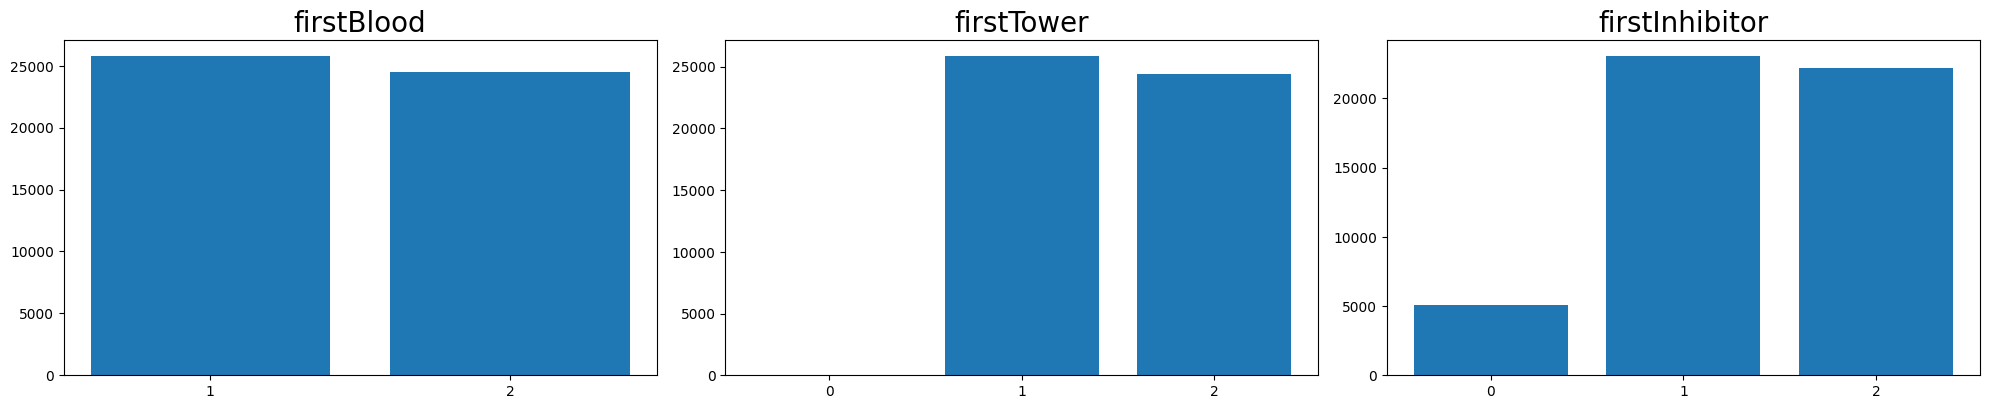

firstTower
1    25861
2    24415
0       18
Name: count, dtype: int64


In [275]:
plt.figure(figsize=(20, 75))

m=1
columnes=["firstBlood", "firstTower", "firstInhibitor"]
for i in columnes: 
    plt.subplot(20,3, m)
    m+=1
    x=df[i].value_counts()

    plt.title(i, fontsize=20)

    plt.bar(x.keys(),x)
    if len(x.keys())<=10: 
        plt.xticks(x.keys(),  fontsize=10)

plt.tight_layout()
plt.show()
print(df["firstTower"].value_counts())



Veiem que tenim molts pocs valors amb firstTower=0, degut a que sempre a la partida es tiren torres. Llavors que no es tiri cap torre pot ser 2 opcions: un Nan o que s'hagin rendit abans de tirar cap torre.
El que farem es posar els valors 0 a la moda. Per no fer data leaking ho fem al pipeline que creem me endavant.

In [276]:
#df[df["firstTower"]==0]= df["firstTower"].mode()[0]

Ara generarem noves columnes segons el tipus de personatge que es juga (normalment els personatges s'anomenen campions). Gràcies a què tenim l'arxiu champion_info podem classificar els campions segons el seu tipus, ja que podem saber el tipus de cada campió entrant a diverses pàgines sobre League Of Legends i també amb els nostres coneixements sobre el joc. 
Aquestes transformacions es fan sobre la pròpia fila (sense dependre d'altres), per tant no hi ha cap data leaking posible

Per tant creem el següent diccionari: 

In [277]:

#tipos utilitzados para clasificar de manera simplista: "Mago", "Guerrero", "Tanque", "Apoyo", "Tirador", "Asesino"  i un campio pot tenir mes d'un tipus
champ_by_tipus={
    "Annie": ["Mago"], 
    "Olaf": ["Guerrero"], 
    "Galio": ["Tanque", "Mago"], 
    "Twisted Fate": ["Mago", "Tirador"], 
    "Xin Zhao": ["Guerrero"], 
    "Urgot": ["Tanque", "Guerrero"], 
    "LeBlanc": ["Mago"], 
    "Vladimir": ["Mago"], 
    "Fiddlesticks": ["Mago"], 
    "Kayle": ["Mago", "Tirador"], 
    "Master Yi": ["Asesino"], 
    "Alistar": ["Tanque"], 
    "Ryze": ["Mago"], 
    "Sion": ["Tanque"], 
    "Sivir": ["Tirador"], 
    "Soraka": ["Apoyo"], 
    "Teemo": ["Mago", "Tirador"], 
    "Tristana": ["Tirador"], 
    "Warwick": ["Guerrero"], 
    "Ashe": ["Tirador"], 
    "Miss Fortune":["Tirador"], 
    "Nunu": ["Tanque", "Mago"], 
    "Tryndamere": ["Guerrero"], 
    "Jax": ["Guerrero"], 
    "Morgana": ["Apoyo", "Mago"], 
    "Zilean": ["Apoyo", "Mago"], 
    "Singed": ["Tanque", "Mago"], 
    "Evelynn": ["Asesino", "Mago"], 
    "Twitch" : ["Tirador", "Mago"],
    "Karthus": ["Mago"], 
    "Cho'Gath": ["Tanque"], 
    "Amumu": ["Tanque"], 
    "Rammus":["Tanque"], 
    "Anivia": ["Mago"], 
    "Shaco": ["Asesino"],
    "Dr. Mundo":["Tanque"], 
    "Sona":["Apoyo"], 
    "Kassadin": ["Mago", "Asesino"], 
    "Irelia": ["Guerrero"], 
    "Janna": ["Apoyo"], 
    "Gangplank": ["Guerrero"], 
    "Corki":  ["Tirador"], 
    "Karma": ["Apoyo"], 
    "Taric":["Tanque", "Apoyo"], 
    "Veigar":["Mago"], 
    "Trundle":["Guerrero"], 
    "Swain": ["Tanque", "Mago"], 
    "Caitlyn": ["Tirador"], 
    "Blitzcrank": ["Apoyo"], 
    "Malphite": ["Tanque"], 
    "Katarina": ["Mago", "Asesino"], 
    "Nocturne": ["Asesino"], 
    "Maokai": ["Tanque"], 
    "Renekton": ["Guerrero"], 
    "Jarvan IV": ["Guerrero"], 
    "Elise": ["Mago", "Asesino"], 
    "Orianna": ["Mago"], 
    "Wukong": ["Guerrero"], 
    "Brand": ["Mago"], 
    "Lee Sin": ["Guerrero"], 
    "Vayne": ["Tirador"], 
    "Rumble": ["Mago"], 
    "Cassiopeia": ["Mago"], 
    "Skarner": ["Tanque"], 
    "Heimerdinger": ["Mago"], 
    "Nasus": ["Tanque", "Guerrero"], 
    "Nidalee": ["Mago", "Guerrero"], 
    "Udyr": ["Tanque", "Guerrero"], 
    "Poppy": ["Tanque"], 
    "Gragas": ["Tanque", "Mago"], 
    "Pantheon": ["Guerrero"], 
    "Ezreal": ["Tirador"], 
    "Mordekaiser": ["Tanque", "Mago"], 
    "Yorick": ["Tanque"], 
    "Akali": ["Asesino", "Mago"], 
    "Kennen": ["Tirador", "Mago"], 
    "Garen": ["Guerrero"], 
    "Leona": ["Tanque"], 
    "Malzahar": ["Mago"], 
    "Talon": ["Asesino"],
    "Riven": ["Guerrero"], 
    "Kog'Maw": ["Tirador"], 
    "Shen": ["Tanque", "Apoyo"], 
    "Lux": ["Mago"], 
    "Xerath": ["Mago"], 
    "Shyvana": ["Guerrero", "Mago"], 
    "Ahri": ["Asesino", "Mago"], 
    "Graves": ["Tirador"], 
    "Fizz": ["Asesino", "Mago"], 
    "Volibear": ["Guerrero", "Mago"],
    "Rengar": ["Asesino"], 
    "Varus": ["Tirador", "Mago"], 
    "Nautilus": ["Tanque"], 
    "Viktor": ["Mago"], 
    "Sejuani": ["Tanque"], 
    "Fiora": ["Guerrero"], 
    "Ziggs": ["Mago"], 
    "Lulu": ["Apoyo"], 
    "Draven": ["Tirador"], 
    "Hecarim": ["Guerrero"], 
    "Kha'Zix": ["Asesino"], 
    "Darius": ["Guerrero"], 
    "Jayce": ["Guerrero", "Tirador"], 
    "Lissandra": ["Mago"], 
    "Diana": ["Mago"], 
    "Quinn": ["Tirador", "Asesino"], 
    "Syndra": ["Mago"], 
    "Aurelion Sol": ["Mago"], 
    "Kayn": ["Guerrero", "Asesino"],    
    "Zyra": ["Mago"], 
    "Gnar": ["Guerrero", "Tirador"], 
    "Zac": ["Tanque"], 
    "Yasuo": ["Guerrero"], 
    "Vel'Koz": ["Mago"], 
    "Taliyah": ["Mago"], 
    "Camille": ["Guerrero"], 
    "Braum": ["Tanque", "Apoyo"], 
    "Jhin": ["Tirador"], 
    "Kindred": ["Tirador"], 
    "Jinx": ["Tirador"],
    "Tahm Kench": ["Tanque", "Apoyo"],
    "Lucian": ["Tirador"],
    "Zed": ["Asesino"],
    "Kled": ["Guerrero"],
    "Ekko": ["Mago", "Asesino"],
    "Vi": ["Guerrero"],
    "Aatrox": ["Guerrero"],
    "Nami": ["Apoyo"],
    "Azir": ["Tirador", "Mago"],
    "Thresh": ["Apoyo"],
    "Illaoi": ["Guerrero"],
    "Rek'Sai": ["Guerrero"],
    "Ivern": ["Apoyo"],
    "Kalista":["Tirador"], 
    "Bard":["Apoyo"], 
    "Rakan":["Apoyo"], 
    "Xayah":["Tirador"], 
    "Ornn": ["Tanque"], 
}

In [278]:
#com les columnes afegides nomes depenen de la mateixa fila no hi ha cap "data leaking"
columnes_campions_equip1=["t1_champ1id", "t1_champ2id", "t1_champ3id", "t1_champ4id", "t1_champ5id"]
columnes_campions_equip2=["t2_champ1id", "t2_champ2id", "t2_champ3id", "t2_champ4id", "t2_champ5id"]

columnes_a_afegir=["equip1_Magos", "equip1_Guerreros", "equip1_Tanques", "equip1_Apoyos", "equip1_Tiradors", "equip1_Asesinos", "equip2_Magos", "equip2_Guerreros", "equip2_Tanques", "equip2_Apoyos", "equip2_Tiradors", "equip2_Asesinos"]
#El que hem pensat es generarem les files "equip1_Mago", "equip1_Guerrero", "equip1_Tanque", "equip1_Apoyo", "equip1_Tirador", "equip1_Asesino"(i el mateix per el equip2) i per cada campio que hi hagi d'aquest tipus augmentar en 1 el valor de la columna. 
#El objectiu d'aixo es que hi hagin mes patrons que es tornin a repetir a les dades de entrenament i a la prediccio. 

#genera columnes a 0
for col in columnes_a_afegir: 
    df[col]=[0]*df.shape[0]

#omplir les columnes
def omplir(row): 
   for i in columnes_campions_equip1: 
      if(str(row[i]) in data_json["data"]):
         tipus=champ_by_tipus[data_json["data"][str(row[i])]["name"]]
         for j in tipus:
            if(j=="Mago"): 
               row["equip1_Magos"]+=1
            elif (j=="Guerrero"): 
               row["equip1_Guerreros"]+=1
            elif (j=="Tanque"): 
               row["equip1_Tanques"]+=1
            elif (j=="Apoyo"): 
               row["equip1_Apoyos"]+=1
            elif (j=="Tirador"): 
               row["equip1_Tiradors"]+=1
            elif (j=="Asesino"): 
               row["equip1_Asesinos"]+=1
            else:
               print("ERROR: rol", j)
      else:
         print("error id: ", str(row[i]))
   
   #hacer lo mismo con equip2
   for i in columnes_campions_equip2: 
      if(str(row[i]) in data_json["data"]):
         tipus=champ_by_tipus[data_json["data"][str(row[i])]["name"]]
         for j in tipus:
            if(j=="Mago"): 
               row["equip2_Magos"]+=1
            elif (j=="Guerrero"): 
               row["equip2_Guerreros"]+=1
            elif (j=="Tanque"): 
               row["equip2_Tanques"]+=1
            elif (j=="Apoyo"): 
               row["equip2_Apoyos"]+=1
            elif (j=="Tirador"): 
               row["equip2_Tiradors"]+=1
            elif (j=="Asesino"): 
               row["equip2_Asesinos"]+=1
            else:
               print("ERROR: rol", j)
      else:
         print("error id: ", str(row[i]))
   return row



df = df.apply(omplir, axis=1)  





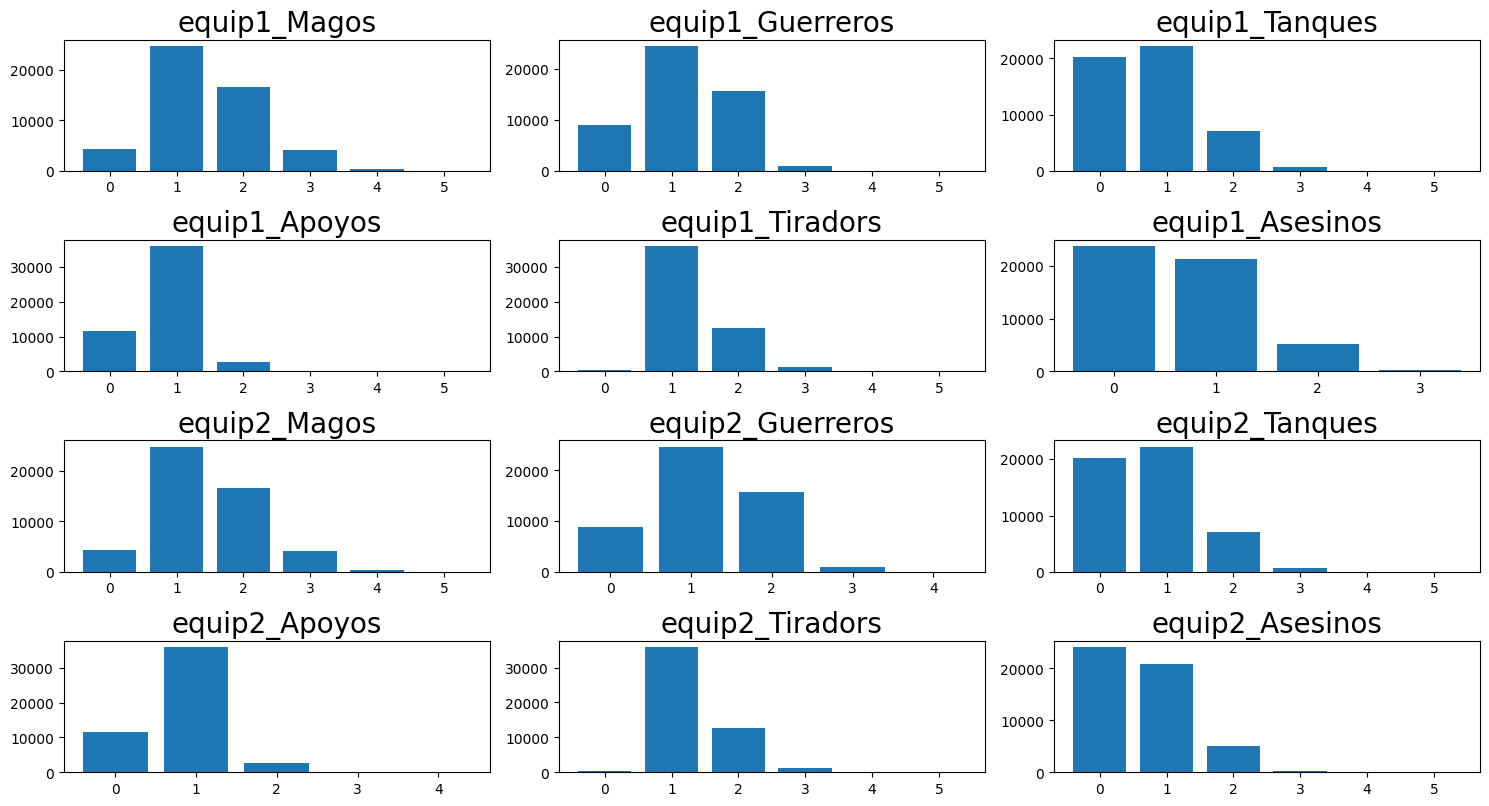

In [279]:

plt.figure(figsize=(15, 40))

m=1

for i in columnes_a_afegir: 
    plt.subplot(20,3, m)
    m+=1
    x=df[i].value_counts()

    plt.title(i, fontsize=20)

    plt.bar(x.keys(),x)
    if len(x.keys())<=10: 
        plt.xticks(x.keys(),  fontsize=10)

plt.tight_layout()
plt.show()

Decidim treure les columnes de bans, que son els campions que s'han elegit per a que no es poguin jugar. Aquesta columna perd tota la importancia ja que en cap cas ens esta informat del que esta passant en la partida. 

In [280]:
columnes_de_bans=['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4','t1_ban5', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']
df=df.drop(columnes_de_bans, axis=1)
df.columns

Index(['gameDuration', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor',
       'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id',
       't1_champ1_sum1', 't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1',
       't1_champ2_sum2', 't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2',
       't1_champ4id', 't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id',
       't1_champ5_sum1', 't1_champ5_sum2', 't1_towerKills',
       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills', 'equip1_Magos', 'equip1_Guerreros',
       'equip1_Tanques', 'equip1_Apoyos', 'equip1_Tir

Tambe eliminem les columnes t1_champ1id, t1_champ2id ... que encara ser valors numèrics (que representen el campio) són variables categoriques.  Això ho fem perque ja hem aconseguit agrupar els diferents campions pel seu tipus. A més aquestes columnes a eliminar podem veure als gràfics que es troben molt desbalancejadas, on hi ha alguns campions que pràcticament no estàn representats.

In [281]:

df.drop(columnes_campions_equip1,inplace=True, axis=1)
df.drop(columnes_campions_equip2,inplace=True, axis=1)

Per normalitzar les dades hem de tenir en compte, que hi hagi moltes dades que semblen continues la realitat es que son categoriques i aquestes no les normalitzarem. Per tant l'única columna que normalitzarem sera la de gameDuration. Utilitzarem StandardScaler que es basa en la funcio normal, ja que com podem veure en la gràfica següent, pren una distribució normal. Aquesta normalització s'aplica al pipeline (creat posteriorment) per evitar data leaking

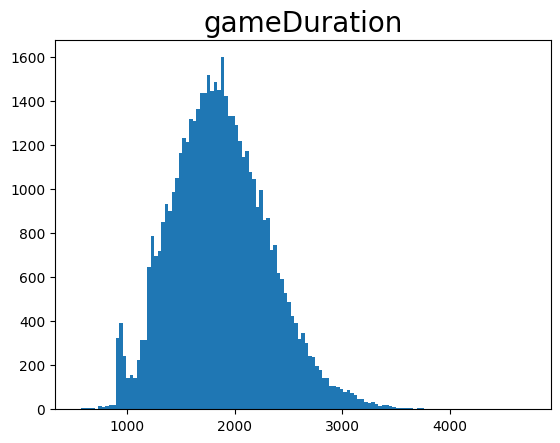

In [282]:
plt.hist(df["gameDuration"], bins="auto")
plt.title("gameDuration", fontsize=20)
plt.show()

Mirem si trobem correlacio entre les diferents variables que disposem

Text(0.5, 1.0, 'Matriu de correlació')

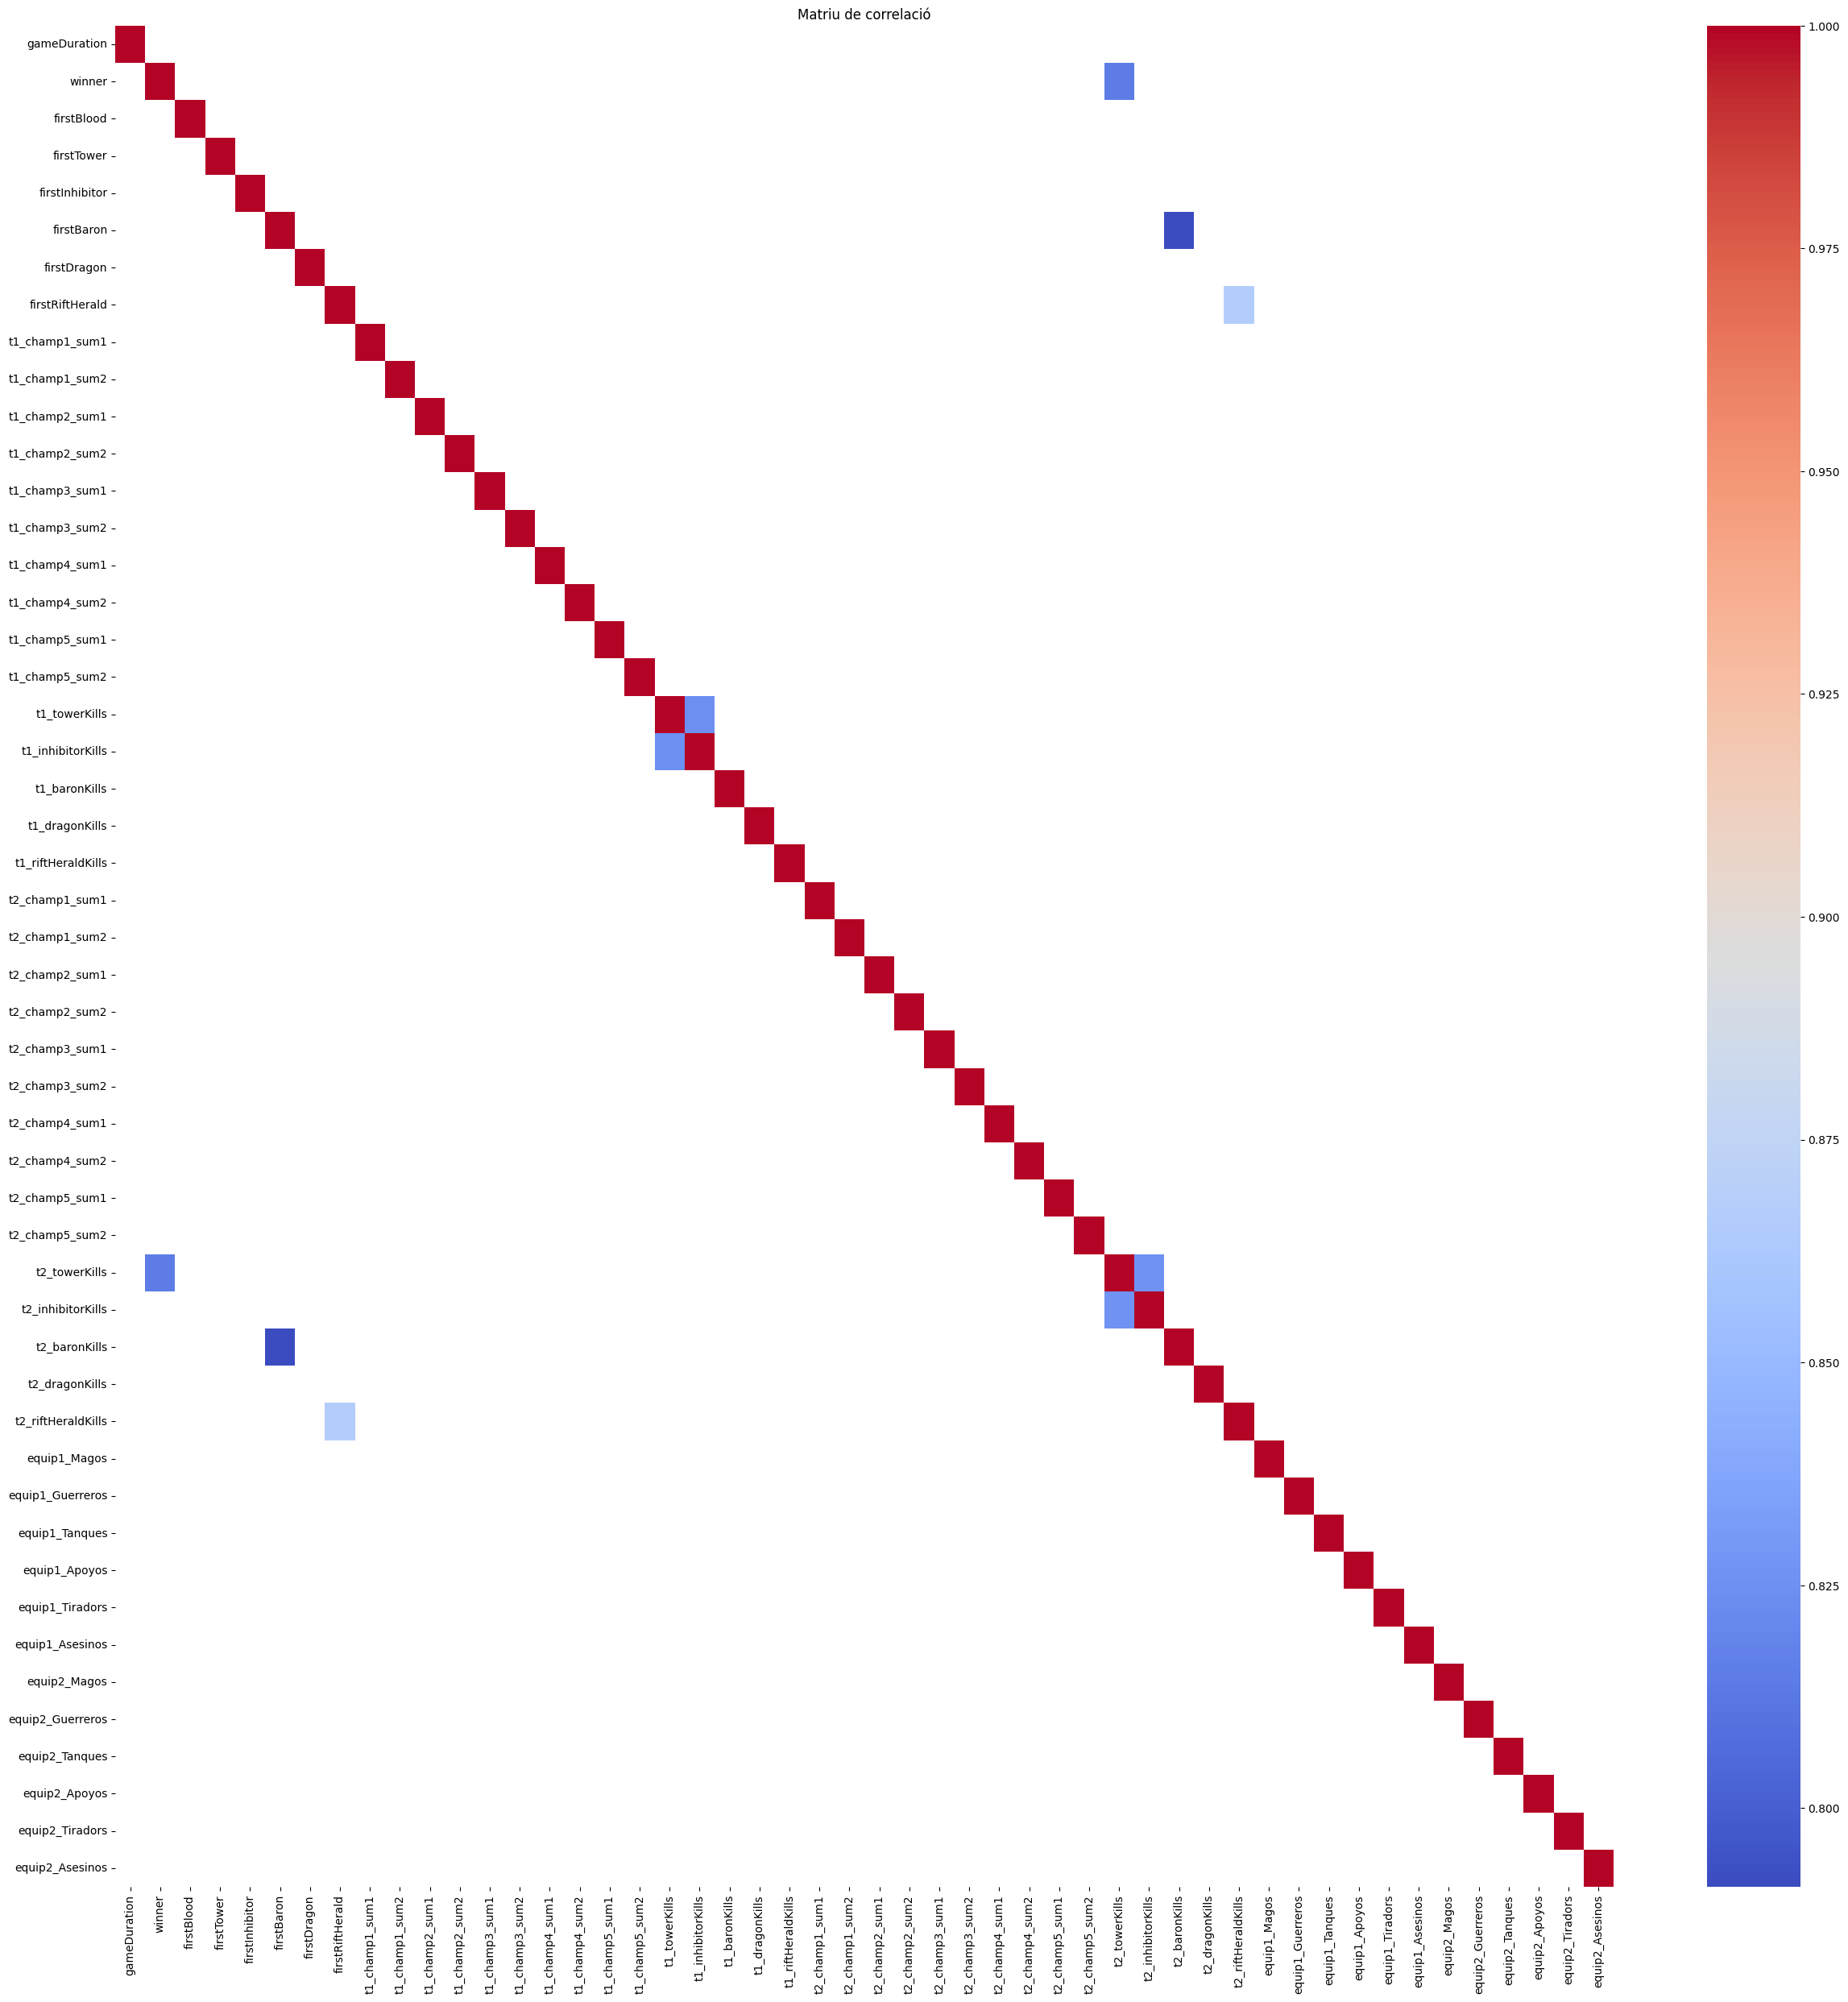

In [283]:

correlation_matrix = df.corr()
plt.figure(figsize=(30, 30))
high_corr = correlation_matrix[correlation_matrix > 0.75]#nomes mostrem aquelles que estan fortament correlacionades
matrix=sns.heatmap(high_corr, cmap='coolwarm', fmt='.1f', annot=False)


matrix.set_title("Matriu de correlació")

Veiem que hi ha dades correlacoinades entre elles, per tant al crear el model sembla que el millor serà utilitzar regularització, Lasso o Ridge. 

També farem one hot encoding dels valors de les columnes sum1/sum2. Ja que un valor de 10 no vol dir que és millor que 1. Si no que té un altre tipus de "habilitat" el qual en el joc s'anomena "summoner" o  en espanyol "hechizo de invocador". Això ens provocarà tenir moltes columnes noves, perquè per cada campió tindrem n columnes (on n es el nombre d'aquests habilitats que hi ha). I tenim un total de 10 campions.
Farem un one-hot encoding on sum1 i sum2 crearan n columnes amb només 2 valors a true. Que s'haurà d'aplicar al pipeline (creat posteriorment) per no fer data leakage

In [284]:


def EncodingOneHot(X):
    data=deepcopy(X) #fet per a que funcioni be amb el Pipeline
    columnes_one_hot_encoder={"t1_c1":["t1_champ1_sum1", "t1_champ1_sum2"], 
                            "t1_c2":["t1_champ2_sum1", "t1_champ2_sum2"], 
                            "t1_c3":["t1_champ3_sum1", "t1_champ3_sum2"], 
                            "t1_c4":["t1_champ4_sum1", "t1_champ4_sum2"], 
                            "t1_c5":["t1_champ5_sum1", "t1_champ5_sum2"], 
                            "t2_c1":["t2_champ1_sum1", "t2_champ1_sum2"], 
                            "t2_c2":["t2_champ2_sum1", "t2_champ2_sum2"], 
                            "t2_c3":["t2_champ3_sum1", "t2_champ3_sum2"], 
                            "t2_c4":["t2_champ4_sum1", "t2_champ4_sum2"], 
                            "t2_c5":["t2_champ5_sum1", "t2_champ5_sum2"],         
                            }  
    summoners_by_champs=[]
    for i in columnes_one_hot_encoder:
        if  not (columnes_one_hot_encoder[i][0] in data.columns and columnes_one_hot_encoder[i][1] in data.columns):
             print(columnes_one_hot_encoder[i][1])
             print(columnes_one_hot_encoder[i][0])
             continue
        columna_combinada =pd.concat([data[columnes_one_hot_encoder[i][0]],data[columnes_one_hot_encoder[i][1]]], axis=0,  ignore_index=True) 
        aux=columna_combinada.unique()
        #print(aux)
        summoners_by_champs.append(aux)#guardem les columnes per despres el predict
        for spell in aux: 
            data[f'{spell}_{i}']=0#creem les noves columnes al train
        
       
        
        for key, spell in data[columnes_one_hot_encoder[i][0]].items(): 
            data.at[key, f'{spell}_{i}']=1
           
        for key, spell in data[columnes_one_hot_encoder[i][1]].items(): 
            data.at[key, f'{spell}_{i}']=1
    
    for i in columnes_one_hot_encoder: 
        data.drop([columnes_one_hot_encoder[i][0], columnes_one_hot_encoder[i][1]], inplace=True, axis=1)

    return summoners_by_champs

#comprobar que la funcio va correctament
#df_aux=deepcopy(df)
#EncodingOneHot(df_aux, columnes_one_hot_encoder)

Per ultim, com busquem predir els valors de la columna "winner", on aquest pren valors 1 o 2. Convertirem els valors 1 a 0  y 2 a 1. 
Per tant ara un valor de 1 en "Winner" indica que el equip 2 a guanyat. Aquest canvi es degut a que necessitem els valors de predicció representats d'aquesta manera per a podre mostrar les corbes ROC i Precission/Recall mes endavant. 

In [285]:
df["winner"]=df["winner"]-1

### 3. Metric selection

Com l'atribut que es busca predir és "Winner" i aquest es troba  balancejat creiem que la millor mètrica per al nostre model és l'accuracy.

Seguidament genero unes funcions que ens serviran per evaluar el model, tant per mostrar les corves pr, roc com per a calcular l'accuracy

In [286]:
def show_pr_curve(model, x, y, classifier_name):

    # predict probabilities
    y_prob = model.predict_proba(x)

    # keep probabilities for the positive outcome only
    y_prob = y_prob[:, 1]

    precision, recall, _ = precision_recall_curve(y, y_prob)

    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {classifier_name}')

    plt.tight_layout()
    plt.show()


In [287]:
def show_roc_curve_binary(model, x, y, classifier_name):

    ns_probs = [1 for _ in range(len(y))] 
    probs = model.predict_proba(x)
    probs = probs[:, 1]

    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    fpr, tpr, threshold = roc_curve(y, probs)

    # Plot stuff:
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sense capacitat predictiva')
    plt.plot(fpr, tpr, marker='.', label=classifier_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')
    plt.legend()
    plt.show()

    return [fpr, tpr]

In [288]:
def show_roc_curve_diversosModels(dicc):
    ns_probs = [1 for _ in range(len(y))] 
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sense capacitat predictiva')
    
    for value in dicc: 
        plt.plot(dicc[value][0], dicc[value][1], marker='.', label=value)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve')
    plt.legend()
    plt.show()

In [289]:
def show_performance(x, y, model, title=''):

    predictions = model.predict(x)
    accuracy=accuracy_score(y, predictions)
    accuracy=round(accuracy, 3)
    
    conf_mat = confusion_matrix(y, predictions)

    # Per PR Curve, necessitem les probabilitats de cada classe:
    

    
    print('-' * 25)
    print(f'>>> Accuracy del model: {accuracy}')
    print('-' * 25)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot()
    plt.title(f'{title} Conf. Mat.')
    plt.show()

    return accuracy



### 4. Model Selection 

Primer de tot creem una funció auxiliar que ens servira per a cada model trobar els millors hiperparàmetres, fent ús de GridSearchCv: 

In [290]:
def hyperparameter_tuning(model, params, x_train, y_train, folds=10, score="accuracy"):
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=folds, n_jobs=-1, scoring=score)
    grid_search.fit(x_train, y_train)

    print(f"Millors hiperparànetres: {grid_search.best_params_} amb accuracy {grid_search.best_score_}")

    return [grid_search.best_estimator_, grid_search.best_params_]

Separem les dades que utilitzem al train i al test final

In [291]:
target_attribut="winner"
X=df.drop([target_attribut], axis=1, inplace=False)
y=df[[target_attribut]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


In [292]:
class OneHotEncodingPersonalitzat(BaseEstimator):
    def __init__(self):
        self.columnes_one_hot_encoder={"t1_c1":["t1_champ1_sum1", "t1_champ1_sum2"], 
                            "t1_c2":["t1_champ2_sum1", "t1_champ2_sum2"], 
                            "t1_c3":["t1_champ3_sum1", "t1_champ3_sum2"], 
                            "t1_c4":["t1_champ4_sum1", "t1_champ4_sum2"], 
                            "t1_c5":["t1_champ5_sum1", "t1_champ5_sum2"], 
                            "t2_c1":["t2_champ1_sum1", "t2_champ1_sum2"], 
                            "t2_c2":["t2_champ2_sum1", "t2_champ2_sum2"], 
                            "t2_c3":["t2_champ3_sum1", "t2_champ3_sum2"], 
                            "t2_c4":["t2_champ4_sum1", "t2_champ4_sum2"], 
                            "t2_c5":["t2_champ5_sum1", "t2_champ5_sum2"],         
                            }  
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X): 
        #print(type(X)) #debe ser tipo pandas
        self.encoding=EncodingOneHot(X)
        return X
    
    def predict(self, X): 
        equips=["t1", "t2"]
        champ=0
        noves_columnes=pd.DataFrame()
        while champ !=9:
            equip=equips[int(champ>4)]
            encoding_champ=self.encoding[champ]
            for spell in encoding_champ:
                noves_columnes[f'{spell}_{equip}_c{champ+1}']=[0]*X.shape[0] 
               
            champ+=1
        
        index=0
        for _, row in X.iterrows():
            for columna in self.columnes_one_hot_encoder: 
                #print(columna)
                #print(row)
                #print(self.columnes_one_hot_encoder[columna][0])
                value1=row[self.columnes_one_hot_encoder[columna][0]]
                value2=row[self.columnes_one_hot_encoder[columna][1]]
                if f'{value1}_{columna}' in noves_columnes:
                    noves_columnes.loc[index, f'{value1}_{columna}']+=1
                if f'{value2}_{columna}' in noves_columnes:
                    noves_columnes.loc[index, f'{value2}_{columna}']+=1
                
            index+=1

        for i in self.columnes_one_hot_encoder: 
            X.drop([self.columnes_one_hot_encoder[i][0], self.columnes_one_hot_encoder[i][1]], inplace=True, axis=1)

        X=pd.concat([X, noves_columnes], axis=1)

        return X

class moda(BaseEstimator):
    def __init__(self):
        self.moda = None  # Atributo para almacenar la moda

    def fit(self, X, y=None):
        self.moda=X["firstTower"].mode()[0]
        return self
    
    def transform(self, X):
        X[X["firstTower"]==0]=self.moda

        return X # Reemplaza los ceros con la moda
    
    def predict(self, X): 
        X[X["firstTower"]==0]=self.moda
        return X

Cració d'un pipeline

In [293]:
def createPipeline(model):
    preprocessor=ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), ["gameDuration"])
        ], 
        remainder='passthrough' #no cambiar el resta de columnes
    )
    pipeline = Pipeline([
        ("moda", moda()),#Pas 1: fer moda per els valors de firstTower a 0
        ("Encoding", OneHotEncodingPersonalitzat()), #Pas 2: fer en encoding
        ('preprocessor', preprocessor),  # Pas 3: Normalizar  
        ('model', model)                # Pas 4: Model
    ])

    return pipeline

Ara el que farem es probar diversos models d'aprenentatge per veure amb quin trobem millors resultats. 
Els models utilizats seran: Regressió Logistica, K-Nearest Neighbors(KNN) i AdaBoostClassifier. Tots aquest models serveixen per fer classificació.
Per a cada model seleccionarem diferents hiperparàmetres i amb GridSearchCV buscarem quin conjunt d'hiperparàmetres  dona millors resultats.

In [294]:
fpr_tpr_diversos_models={}

#### Logistic Regression

In [295]:
lr=LogisticRegression()
params_lr=dict(model__penalty=["l1", "l2"], model__C=[0.01, 0.1, 1, 3], model__solver=["liblinear"])

pipeline_lr=createPipeline(lr)

estimator_lr, _=hyperparameter_tuning(pipeline_lr, params_lr, X_train, y_train.values.ravel(), folds=5)


Millors hiperparànetres: {'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'liblinear'} amb accuracy 0.9718652914129489


-------------------------
>>> Accuracy del model: 0.976
-------------------------


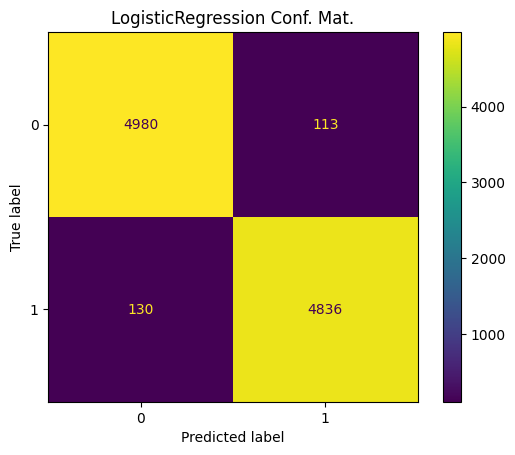

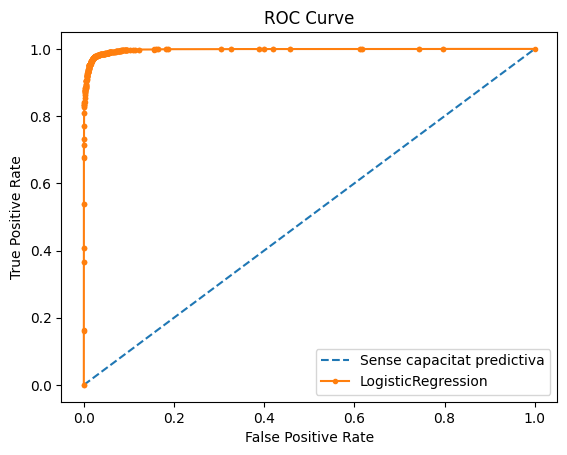

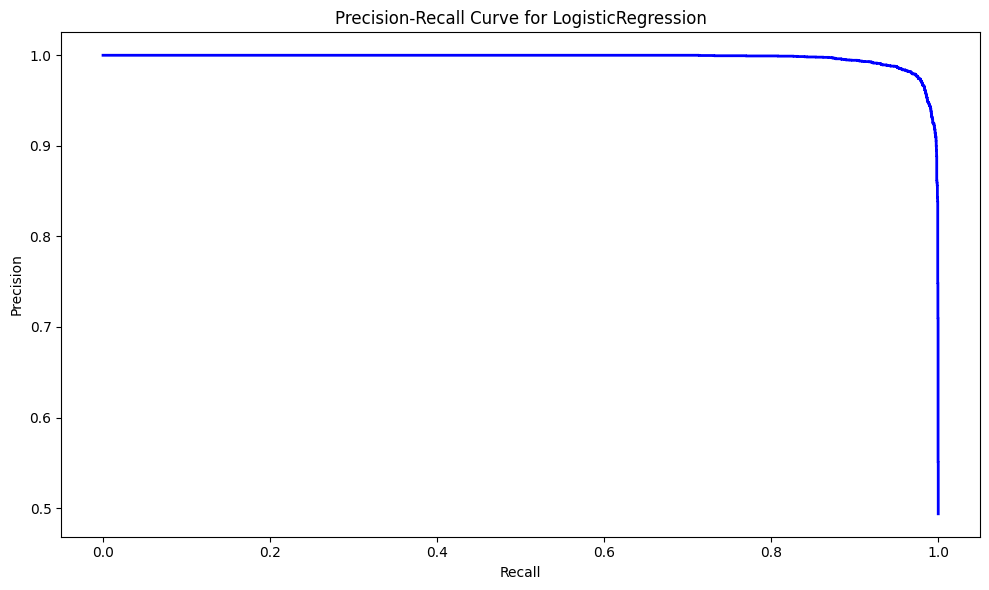

In [296]:
show_performance(X_test, y_test, estimator_lr, "LogisticRegression")
fpr_tpr_diversos_models["LogisticRegression"]=show_roc_curve_binary(estimator_lr, X_test, y_test, "LogisticRegression")
show_pr_curve(estimator_lr, X_test, y_test, "LogisticRegression")

#### KNeighborsClassifier

In [297]:

knn=KNeighborsClassifier()

params_knn=dict(model__n_neighbors=[3, 5, 10, 20, 30], model__weights=["uniform", "distance"], model__p=[1,2])


pipeline_knn=createPipeline(knn)
estimator_knn, _= hyperparameter_tuning(pipeline_knn, params_knn, X_train, y_train.values.ravel(), folds=5)

Millors hiperparànetres: {'model__n_neighbors': 30, 'model__p': 2, 'model__weights': 'distance'} amb accuracy 0.9611283708214241


-------------------------
>>> Accuracy del model: 0.963
-------------------------


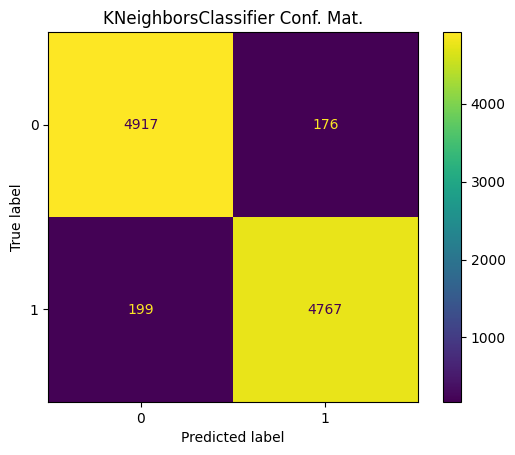

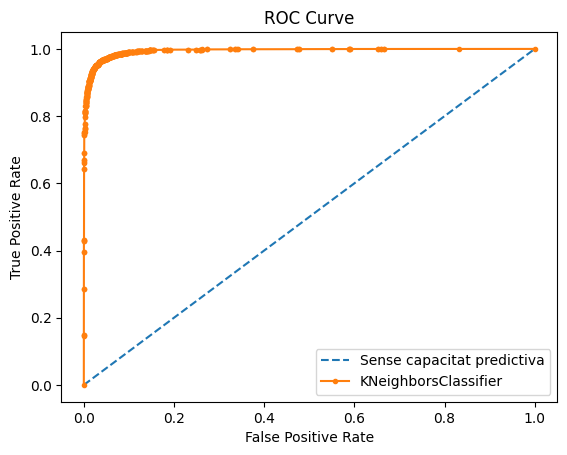

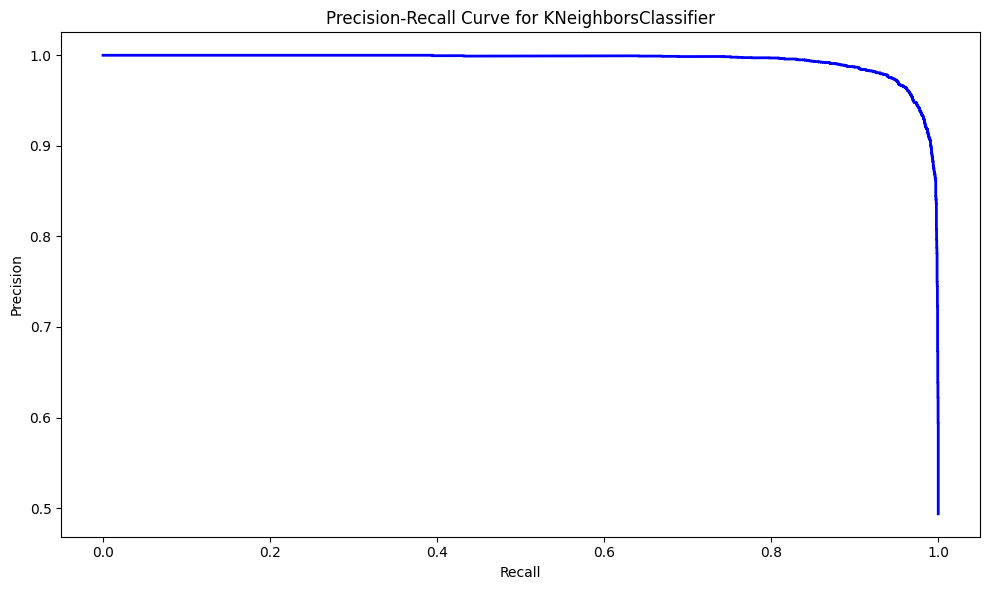

In [298]:
show_performance(X_test, y_test, estimator_knn, "KNeighborsClassifier")
fpr_tpr_diversos_models["KNeighborsClassifier"]=show_roc_curve_binary(estimator_knn, X_test, y_test, "KNeighborsClassifier")
show_pr_curve(estimator_knn, X_test, y_test, "KNeighborsClassifier")

### AdaBoostClassifier

In [299]:
abc = AdaBoostClassifier(algorithm="SAMME")
params_abc=dict(model__n_estimators=[30, 50, 80, 100, 150], model__learning_rate=[0.01, 0.1, 1, 2, 3])

pipeline_abc=createPipeline(abc)
estimator_abc, _= hyperparameter_tuning(pipeline_abc, params_abc, X_train, y_train.values.ravel(), folds=5)

Millors hiperparànetres: {'model__learning_rate': 1, 'model__n_estimators': 150} amb accuracy 0.976662110103144


-------------------------
>>> Accuracy del model: 0.98
-------------------------


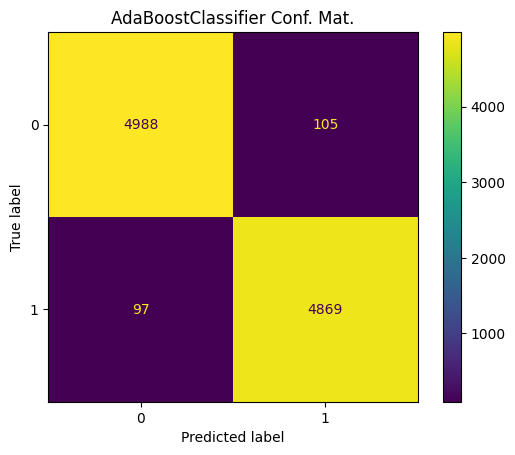

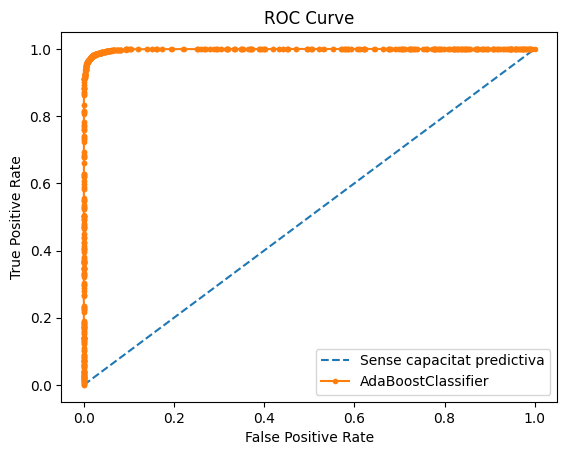

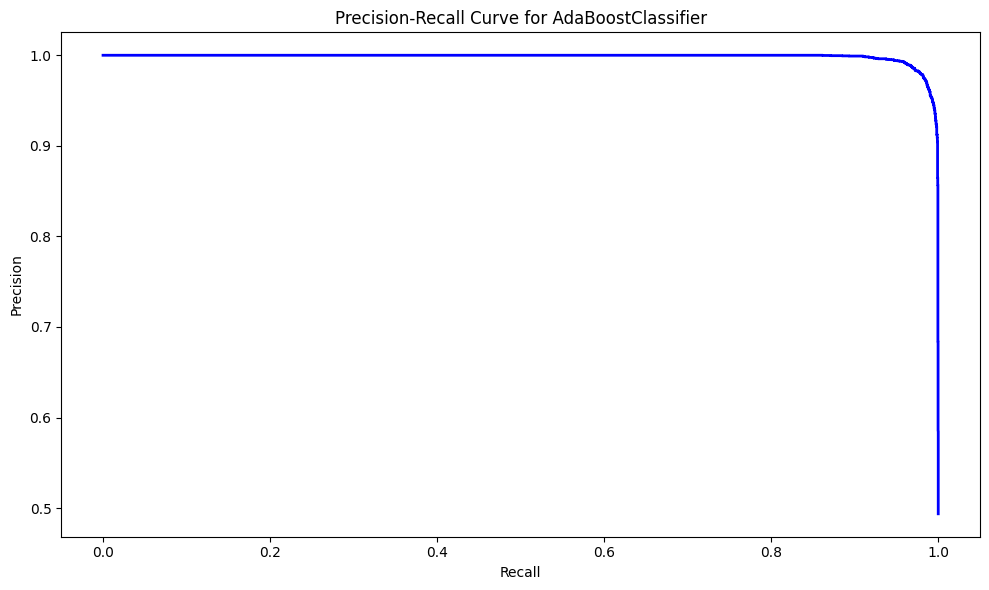

In [300]:
show_performance(X_test, y_test, estimator_abc, "AdaBoostClassifier")
fpr_tpr_diversos_models["AdaBoostClassifier"]=show_roc_curve_binary(estimator_abc, X_test, y_test, "AdaBoostClassifier")
show_pr_curve(estimator_abc, X_test, y_test, "AdaBoostClassifier")

Per comparar els models d'una manera més gràfica: 

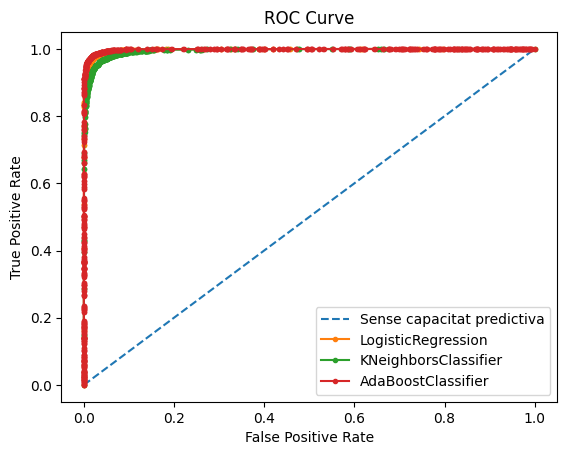

In [301]:
show_roc_curve_diversosModels(fpr_tpr_diversos_models)

Com podem observar els tres models obtenen uns resultats molt bons, tots sobrepassen el 95% d'accuracy. El model que millor rendiment es AdaBoostClassifier amb parametres: 'model__learning_rate': 1, 'model__n_estimators': 150